In [1]:
import raw_data
import ta

import math

from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
daily_adjusted_df = raw_data.get_time_series_daily_adjusted("msft")
prediction_period = 1  # predict 1 day into the future

display.display(daily_adjusted_df.describe())
display.display(daily_adjusted_df.head(5))

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
count,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5.960000e+03,5960.000000,5960.000000
mean,55.470969,56.162841,54.785379,55.494916,26.638197,4.237067e+07,0.002562,1.000671
std,34.166645,34.658273,33.658528,34.197385,18.961481,3.046236e+07,0.046281,0.025900
min,15.200000,15.620000,14.870000,15.150000,2.423500,7.111000e+05,0.000000,1.000000
25%,27.417500,27.710000,27.210000,27.457500,17.478850,2.185800e+07,0.000000,1.000000
50%,43.980000,44.500000,43.555000,43.990000,21.428700,3.814835e+07,0.000000,1.000000
75%,77.597500,79.025000,76.690000,77.690000,28.917300,5.712868e+07,0.000000,1.000000
max,178.940000,180.380000,175.750000,179.940000,112.330000,5.910522e+08,3.080000,2.000000


,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2018-08-31,111.685,112.777,111.515,112.33,112.33,23216875,0.0,1.0
1,2018-08-30,111.670,112.610,111.440,111.95,111.95,22798702,0.0,1.0
2,2018-08-29,110.450,112.030,110.270,112.02,112.02,20818044,0.0,1.0
3,2018-08-28,109.940,110.500,109.790,110.26,110.26,19151528,0.0,1.0
4,2018-08-27,109.270,109.640,108.510,109.60,109.60,19662331,0.0,1.0


In [3]:
def preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period, means=None, stds=None):
    selected_features = daily_adjusted_df[[
        "open",
        "high",
        "low",
        "adjusted_close",
        "volume"
    ]]

    # Truncate the most recent prediction_period days
    processed_df = selected_features.iloc[prediction_period:].copy()
    
    # Add technical indicators
    ta.add_all_ta_features(processed_df, "open", "high", "low", "adjusted_close", "volume", fillna=True)
    processed_df = processed_df.drop("volatility_kchi", axis=1)

    if means is None:
        means = processed_df.mean().copy()
    if stds is None:
        stds = processed_df.std().copy()

    # Normalize features
    processed_df = (processed_df - means) / stds
    
    # Add the target column
    if prediction_period == 0:
        processed_df["future_percent_change"] = 0
    else:
        start_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[prediction_period:].values
        end_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[:-prediction_period].values
        processed_df["future_percent_change"] = (end_adjusted_closes - start_adjusted_closes) / start_adjusted_closes * 100.0
        
    return processed_df, means, stds

In [4]:
def preprocess_features(df):
    processed_features = df.iloc[:, df.columns != "future_percent_change"].copy()
    return processed_features

def preprocess_targets(df):
    processed_targets = df["future_percent_change"].copy()
    return processed_targets

In [5]:
df, means, stds = preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period)
display.display(df.describe())
display.display(df.head(5))

df = df.sample(frac=1)  # Shuffle df

,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_percent_change
count,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,...,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5959.000000
mean,5.608983e-15,6.562892e-15,7.593113e-15,5.876078e-15,1.907817e-17,6.105016e-16,-1.430863e-17,-4.769543e-18,1.526254e-15,1.788579e-17,...,-2.442006e-15,2.480163e-16,-2.060443e-15,4.960325e-16,-3.205133e-15,7.631270e-17,-8.346701e-18,8.346701e-18,-4.273511e-15,0.083721
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.984872
min,-1.178556e+00,-1.169678e+00,-1.185792e+00,-1.278374e+00,-1.367611e+00,-7.778027e+00,-1.139119e+01,-4.325398e+00,-5.309731e+00,-3.670229e+01,...,-6.162033e+00,-6.026775e+00,-7.143713e+00,-6.911664e+00,-7.143713e+00,-3.177697e+00,-8.227952e+00,-8.986132e+00,-1.278374e+00,-15.606725
25%,-8.209924e-01,-8.207946e-01,-8.191125e-01,-4.831143e-01,-6.734850e-01,-4.603877e-01,-7.219137e-01,-4.813141e-01,-5.577705e-01,-4.760178e-02,...,-7.184231e-01,-1.949910e-01,-4.704856e-01,-4.758647e-01,-4.704856e-01,-2.275620e-01,-4.778304e-01,-4.708719e-01,-4.831143e-01,-0.867729
50%,-3.363860e-01,-3.365711e-01,-3.335735e-01,-2.744463e-01,-1.385863e-01,1.917199e-01,-3.820392e-02,-1.127155e-02,1.845463e-01,1.344013e-02,...,-2.169004e-02,-8.574325e-02,2.394569e-01,2.368061e-01,2.394569e-01,-3.157417e-02,7.647895e-03,1.757357e-02,-2.744463e-01,0.029180
75%,6.474629e-01,6.588573e-01,6.501331e-01,1.210258e-01,4.843691e-01,7.688946e-01,7.341295e-01,4.373455e-01,7.544168e-01,6.516727e-02,...,7.526565e-01,-1.908928e-02,7.384451e-01,7.396618e-01,7.384451e-01,1.693027e-01,4.634749e-01,4.719211e-01,1.210258e-01,1.002397
max,3.614524e+00,3.584831e+00,3.594716e+00,4.511027e+00,1.801077e+01,1.257206e+00,6.159403e+00,7.336595e+00,1.364429e+00,1.831073e+01,...,7.478065e+00,7.803166e+00,1.308217e+00,1.295186e+00,1.308217e+00,1.246479e+01,9.342215e+00,8.592048e+00,4.511027e+00,19.575074


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_percent_change
1,1.645363,1.629180,1.683760,4.507329,-0.642570,1.241166,0.003426,0.010619,1.364429,0.013702,...,0.457942,7.803166,1.195655,1.209596,1.195655,0.018982,0.022336,0.032278,4.507329,0.339437
2,1.609650,1.612443,1.648994,4.511027,-0.707586,1.250611,0.404767,0.010619,1.364429,0.013702,...,7.478065,7.803166,1.195655,1.209596,1.195655,0.018982,0.053848,0.063811,4.511027,-0.062489
3,1.594721,1.568291,1.634731,4.418055,-0.762291,1.255493,-0.365787,0.010619,1.364429,0.198756,...,-5.162992,7.803166,1.195655,1.209596,1.195655,0.018982,-0.769478,-0.766593,4.418055,1.596227
4,1.575109,1.543474,1.596696,4.383191,-0.745523,1.254256,-0.375635,0.010619,1.364429,0.097671,...,-5.649100,7.803166,1.195655,1.209596,1.195655,0.018982,-0.279334,-0.270590,4.383191,0.602190
5,1.528273,1.512308,1.568467,4.319801,-0.825234,1.257206,-0.328820,0.010619,1.364429,0.120781,...,-5.890663,7.803166,1.195655,1.209596,1.195655,0.018982,-0.529458,-0.523094,4.319801,1.107011


In [6]:
num_rows = len(df)
# Use 90% for training and rest for validation
num_training = int(num_rows * 0.9)
num_validation = num_rows - num_training

training_examples = preprocess_features(df.head(num_training))
training_targets = preprocess_targets(df.head(num_training))

validation_examples = preprocess_features(df.tail(num_validation))
validation_targets = preprocess_targets(df.tail(num_validation))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,...,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000
mean,-0.001716,-0.001875,-0.001695,0.001357,-0.002182,0.003261,-0.000921,-0.001080,0.002825,0.006726,...,0.001931,0.007657,0.000034,0.004149,0.004069,0.004149,0.001799,0.005307,0.005544,0.001357
std,0.997785,0.997691,0.997846,0.997634,0.995156,0.989764,0.997353,1.000992,0.997633,0.983147,...,1.001648,1.001138,0.993594,0.989413,0.990694,0.989413,1.005320,0.989244,0.987966,0.997634
min,-1.173875,-1.169678,-1.185792,-1.278374,-1.367611,-7.778027,-11.391186,-4.325398,-5.309731,-36.702286,...,-3.130318,-6.162033,-6.026775,-7.143713,-6.911664,-7.143713,-3.177697,-8.227952,-8.986132,-1.278374
25%,-0.820261,-0.820217,-0.818667,-0.479760,-0.670380,-0.453962,-0.719513,-0.481170,-0.552732,-0.045700,...,-0.714150,-0.708240,-0.195234,-0.474776,-0.475609,-0.474776,-0.221923,-0.474551,-0.467557,-0.479760
50%,-0.336386,-0.337148,-0.333276,-0.271810,-0.138478,0.183277,-0.034861,-0.011884,0.190111,0.013467,...,0.019615,-0.012153,-0.085668,0.245270,0.245317,0.245270,-0.030664,0.013201,0.023133,-0.271810
75%,0.631363,0.626682,0.634236,0.121942,0.479347,0.768197,0.737659,0.441405,0.753579,0.066760,...,0.698825,0.761419,-0.018698,0.735045,0.737516,0.735045,0.169819,0.464365,0.472805,0.121942
max,3.614524,3.584831,3.594716,4.511027,18.010770,1.257206,6.159403,7.336595,1.364429,18.310734,...,3.383742,7.478065,7.803166,1.308217,1.295186,1.308217,12.464792,9.342215,8.592048,4.511027


Validation examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,...,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000
mean,0.015439,0.016874,0.015251,-0.012208,0.019633,-0.029345,0.008289,0.009719,-0.025419,-0.060523,...,-0.017373,-0.068902,-0.000308,-0.037331,-0.036611,-0.037331,-0.016187,-0.047759,-0.049888,-0.012208
std,1.020439,1.021237,1.019900,1.021816,1.043236,1.088238,1.024330,0.991808,1.021555,1.139647,...,0.985704,0.987868,1.056771,1.090842,1.080343,1.090842,0.951448,1.091767,1.102040,1.021816
min,-1.178556,-1.166215,-1.178958,-1.274296,-1.355765,-7.468550,-4.401089,-3.733631,-4.542794,-24.138532,...,-3.151159,-3.762256,-4.597092,-5.464858,-5.849346,-5.464858,-3.146883,-7.883151,-8.575118,-1.274296
25%,-0.824505,-0.826061,-0.822975,-0.502432,-0.706506,-0.528076,-0.735748,-0.487508,-0.601673,-0.061832,...,-0.660198,-0.814223,-0.191577,-0.457867,-0.478931,-0.457867,-0.255844,-0.501244,-0.494549,-0.502432
50%,-0.327458,-0.329213,-0.343231,-0.299353,-0.140960,0.244879,-0.066182,-0.008139,0.153343,0.013014,...,-0.028819,-0.115682,-0.086583,0.195151,0.181804,0.195151,-0.037897,-0.005660,0.004247,-0.299353
75%,0.780360,0.775729,0.775752,0.099224,0.534340,0.776073,0.722650,0.408855,0.763186,0.061871,...,0.693318,0.642875,-0.020704,0.754783,0.763568,0.754783,0.161137,0.453037,0.461563,0.099224
max,3.442402,3.575597,3.498143,4.425414,7.086917,1.235905,4.982470,5.452851,1.364429,3.029399,...,2.537065,2.420275,7.803166,1.306342,1.282032,1.306342,10.077882,6.767746,6.369002,4.425414


Training targets summary:


count    5363.000000
mean        0.072241
std         1.958166
min       -15.606725
25%        -0.869465
50%         0.019476
75%         0.995760
max        19.575074
Name: future_percent_change, dtype: float64

Validation targets summary:


count    596.000000
mean       0.187018
std        2.209848
min      -11.804519
25%       -0.847371
50%        0.055584
75%        1.049814
max       18.604776
Name: future_percent_change, dtype: float64

In [7]:
display.display(validation_examples.head(5))
display.display(validation_targets.head(5))

,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
1543,-0.760545,-0.768275,-0.764734,-0.081583,-0.475096,0.751647,-0.534456,0.406978,0.636946,0.354419,...,0.847705,0.330120,0.024605,0.579247,0.630802,0.579247,0.004824,-0.351452,-0.343265,-0.081583
2482,-0.949060,-0.954981,-1.006613,-0.520799,3.534706,0.428964,-2.889408,1.859071,1.021136,0.052551,...,1.163038,1.069613,-0.182907,0.669944,0.745802,0.669944,0.202228,-1.761294,-1.785432,-0.520799
1849,-0.848948,-0.845035,-0.843181,-0.243961,1.241670,-0.843548,1.549563,3.405766,0.574491,-0.236274,...,1.555801,0.474320,0.243490,0.798949,0.708111,0.798949,0.219582,1.558227,1.546690,-0.243961
4024,-0.240372,-0.207868,-0.242052,-0.561036,-0.050791,-0.356779,-0.783650,0.594964,-0.241837,0.016198,...,0.721777,-0.269281,-0.060912,-0.229332,-0.126942,-0.229332,0.120975,-1.081016,-1.084407,-0.561036
3438,-0.837824,-0.838398,-0.832484,-0.359980,0.987714,-1.765171,1.400415,1.766184,-0.270543,0.022843,...,1.038777,1.596744,0.036514,-0.104657,-0.190784,-0.104657,0.125829,0.078879,0.088844,-0.359980


1543    0.747227
2482    3.668997
1849   -2.957442
4024    2.238316
3438   -0.112069
Name: future_percent_change, dtype: float64

In [8]:
def construct_feature_columns(input_features):
    return [tf.feature_column.numeric_column(feature) for feature in input_features]

In [9]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(val) for key, val in dict(features).items()}

    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)

    if shuffle:
        ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [10]:
def train_nn_regression_model(
    optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    periods = 10
    steps_per_period = steps / periods
    
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units,
        optimizer=optimizer)
    
    training_input_fn = lambda: input_fn(training_examples, training_targets, batch_size=batch_size)
    predict_training_input_fn = lambda: input_fn(training_examples, training_targets, num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: input_fn(validation_examples, validation_targets, num_epochs=1, shuffle=False)
    
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range(periods):
        # Train the model, starting from the prior state.
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item["predictions"][0] for item in training_predictions])

        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.3f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.3f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.3f" % validation_root_mean_squared_error)

    return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 0.284
  period 01 : 0.159
  period 02 : 0.114
  period 03 : 0.094
  period 04 : 0.073
  period 05 : 0.082
  period 06 : 0.054
  period 07 : 0.059
  period 08 : 0.051
  period 09 : 0.054
Model training finished.
Final RMSE (on training data):   0.054
Final RMSE (on validation data): 0.079


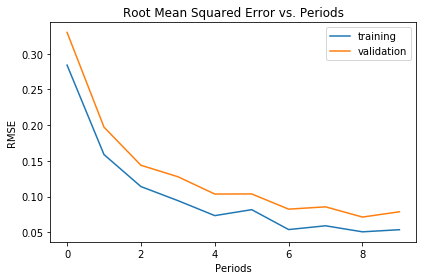

In [26]:
adam_regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.AdamOptimizer(learning_rate=0.0005),
    steps=6000,
    batch_size=30,
    hidden_units=[30, 30, 20, 20, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 0.264
  period 01 : 0.182
  period 02 : 0.148
  period 03 : 0.130
  period 04 : 0.115
  period 05 : 0.104
  period 06 : 0.098
  period 07 : 0.092
  period 08 : 0.085
  period 09 : 0.086
Model training finished.
Final RMSE (on training data):   0.086
Final RMSE (on validation data): 0.144


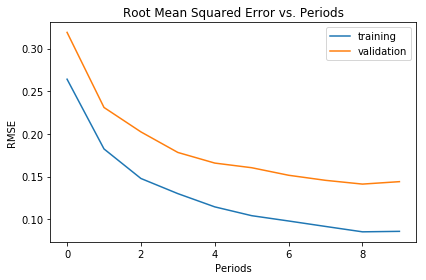

In [27]:
adagrad_regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.008),
    steps=6000,
    batch_size=30,
    hidden_units=[30, 30, 20, 20, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

(59, 30)
Darker corresponds to more negative, lighter corresponds to more positive.


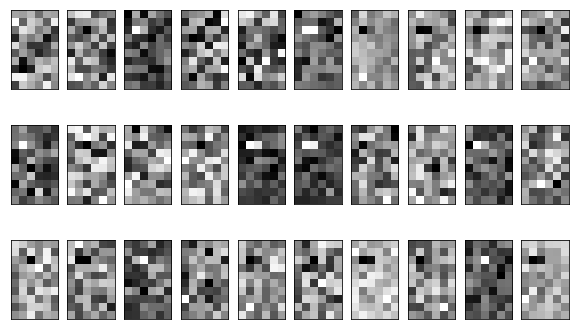

In [28]:
# Visualize weights from first layer
regressor = adam_regressor

weights0 = regressor.get_variable_value("dnn/hiddenlayer_0/kernel")
print(weights0.shape)

num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(10, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    padded = np.pad(coef, (0, 1), "constant")
    cax = ax.matshow(np.expand_dims(padded, 0).reshape(10, 6), cmap=plt.cm.gray)
    ax.set_xticks(())
    ax.set_yticks(())

print("Darker corresponds to more negative, lighter corresponds to more positive.")
plt.show()

In [29]:
recent_df, _, _ = preprocess_daily_adjusted_df(daily_adjusted_df.head(prediction_period + 365), 0, means, stds)
recent_features = preprocess_features(recent_df).head(prediction_period)
recent_targets = preprocess_targets(recent_df).head(prediction_period)
predict_recent_input_fn = lambda: input_fn(recent_features, recent_targets, num_epochs=1, shuffle=False)
predictions = regressor.predict(input_fn=predict_recent_input_fn)
predictions = [item["predictions"][0] for item in predictions]
print("Current predictions (start of array is furthest into the future and end of array is 1 day into the future):")
display.display(predictions)

Current predictions (start of array is furthest into the future and end of array is 1 day into the future):


[0.08805497]